In [1]:
import sys
import os

# Make parent dir importable and move working dir one level up 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
os.chdir("..")

import torch
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from train_prob_unet_model import get_args
from prob_unet import ProbabilisticUNet
import climex_utils as cu
import random
import torch.nn.functional as F
from metrics import crps_over_groundtruth, compute_mae

plt.rcParams["figure.figsize"] = (6,4)
print("Working directory:", os.getcwd())

Pysteps configuration file found at: /home/maalih@labos.polymtl.ca/anaconda3/envs/diffusion/lib/python3.12/site-packages/pysteps/pystepsrc

Working directory: /home/maalih@labos.polymtl.ca/prob-unet-mds


In [2]:
def set_seed(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  
    os.environ['PYTHONHASHSEED'] = str(seed)

# -- 1) Set seed for reproducibility
set_seed(42) 
args = get_args()
args.lowres_scale = 16
args.batch_size = 32


dataset_test = cu.climex2torch(
    datadir=args.datadir,
    years=args.years_test,
    variables=args.variables,
    coords=args.coords,
    lowres_scale=args.lowres_scale,
    type="lrinterp_to_residuals",
    transfo=True
)

# 4) Create the test DataLoader
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=0
)


print("Test samples:", len(dataset_test), "| Batch size:", args.batch_size)
print("Variables:", args.variables)



Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Test samples: 3650 | Batch size: 32
Variables: ['pr', 'tasmin', 'tasmax']


In [3]:
def invert_transfo_3vars(data_3ch: torch.Tensor) -> torch.Tensor:
    """
    data_3ch shape: [*, 3, H, W] in the same 'transfo' domain as stored in dataset.
    Returns the real-domain [*, 3, H, W] in mm/day (for pr) and °C (for tasmin, tasmax).
    """
    # Imports from climex_utils
    from climex_utils import softplus, softplus_inv, kgm2sTommday, KToC

    # Ensure we work in float
    data_3ch = data_3ch.float()

    # Split the three variables
    pr_stored    = data_3ch[:, 0, ...]  # shape [* , H, W]
    tasmin_stored= data_3ch[:, 1, ...]
    tasmax_stored= data_3ch[:, 2, ...]

    # 1) Precip => pr_real in mm/day
    pr_real = kgm2sTommday( softplus(pr_stored) )

    # 2) tasmin => in Kelvin originally, so we just do KToC
    tasmin_real = KToC(tasmin_stored)

    # 3) tasmax => we stored softplus_inv(tasmax - tasmin). 
    #    Invert => tasmax = softplus(tasmax_stored) + tasmin_stored
    #    Then convert from K to °C
    tasmax_real = KToC( softplus(tasmax_stored) + tasmin_stored )

    # Re-stack
    return torch.stack([pr_real, tasmin_real, tasmax_real], dim=1)


In [4]:
# CORRECTED FUNCTION: Nearest Neighbor Interpolation Baseline
def nearest_neighbor_baseline(dataloader):
    """
    Create nearest neighbor interpolated predictions as baseline.
    Uses lrinterp (low-res interpolated to high-res) as the baseline.
    Returns predictions in real domain with shape [T, 3, H, W] (no ensemble dimension)
    """
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            lrinterp = batch['lrinterp']  # [B, 3, H, W] - low-res interpolated to high-res grid, in transfo domain
            
            # Convert from transfo domain to real domain
            lrinterp_real = []
            for i in range(lrinterp.shape[0]):
                real_sample = invert_transfo_3vars(lrinterp[i:i+1]).squeeze(0)
                lrinterp_real.append(real_sample)
            lrinterp_real = torch.stack(lrinterp_real, dim=0)  # [B, 3, H, W] real domain
            
            predictions.append(lrinterp_real.numpy())
    
    return np.concatenate(predictions, axis=0)  # [T, 3, H, W]

In [5]:
# ------------------------------------------------------------
# 2) Low-level PSD of a single 2-D field
# ------------------------------------------------------------
def psd(image2d: torch.Tensor):
    """
    Compute azimuthally-averaged 2-D power spectral density.

    image2d : torch.Tensor [H,W]  (real domain; NOT batched)
    Returns  : k (spatial wavenumber)  and  P(k)
    """
    H, W = image2d.shape
    fourier = torch.fft.fftn(image2d)
    power   = torch.abs(fourier) ** 2         # |F(k)|²

    # Radial frequency grid
    kfreq = torch.fft.fftfreq(H) * H
    kx, ky = torch.meshgrid(kfreq, kfreq, indexing='ij')
    kr     = torch.sqrt(kx**2 + ky**2).flatten().cpu().numpy()
    powerf = power.flatten().cpu().numpy()

    kbins = np.arange(0.5, H//2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    psd_vals, _, _ = stats.binned_statistic(
        kr, powerf, statistic="mean", bins=kbins
    )
    psd_vals *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)   # 2-D shell area
    return kvals, psd_vals

# ------------------------------------------------------------
# 3) PSD over a 4-D or 5-D tensor
#    hr            : [T, 3, H, W]
#    preds         : [T, M, 3, H, W]   (optional ensemble dim)
#    transfo == True  →  data still in stored-transform space
# ------------------------------------------------------------
def compute_psd_tensor(data: torch.Tensor, transfo: bool):
    """
    Returns dict {'pr': P(k), 'tasmin': P(k), 'tasmax': P(k)}
    averaged over all time steps (and ensemble members if present).
    """
    # bring to (N, 3, H, W) where N = T  or  (T*M)
    if data.dim() == 5:                                 # predictions
        T, M, C, H, W = data.shape
        data_use = data.reshape(T*M, C, H, W)
    else:                                               # ground truth
        data_use = data

    psd_acc = {'pr': [], 'tasmin': [], 'tasmax': []}

    for sample in data_use:            # iterate over N samples
        # undo transforms if needed
        s = sample.clone()
        if transfo:
            s[0] = cu.softplus(s[0])                                   # pr
            s[2] = cu.softplus(s[2], c=0) + s[1]                       # tasmax

        # now convert to real units
        s[0] = cu.kgm2sTommday(s[0])
        s[1] = cu.KToC(s[1])
        s[2] = cu.KToC(s[2])

        for idx, key in enumerate(['pr', 'tasmin', 'tasmax']):
            _, p = psd(s[idx])
            psd_acc[key].append(p)

    # mean over samples → array length ~H/2 for every var
    return {k: np.mean(np.stack(v, axis=0), axis=0) for k, v in psd_acc.items()}

In [6]:

# We'll iterate over dataloader once to cache GT in transfo domain (no model yet).

all_hr_transformed = []

with torch.no_grad():
    for batch in dataloader_test:
        hr_trans = batch['hr']  # [B, 3, H, W], still transfo domain
        all_hr_transformed.append(hr_trans.numpy())

all_hr_trans_torch = torch.from_numpy(np.concatenate(all_hr_transformed, axis=0))  # [T, 3, H, W]

# k-axis from a representative field
kvals, _ = psd(all_hr_trans_torch[0, 0])
print("Cached GT (transfo) shape:", tuple(all_hr_trans_torch.shape))



Computing statistics for standardization
Cached GT (transfo) shape: (3650, 3, 128, 128)


In [7]:

def load_probunet(model_path: str) -> ProbabilisticUNet:
    model = ProbabilisticUNet(
        input_channels=len(args.variables),
        num_classes=len(args.variables),
        latent_dim=16,
        num_filters=[32, 64, 128, 256],
        model_channels=32,
        channel_mult=[1, 2, 4, 8],
        beta_0=0.0,
        beta_1=0.0,
        beta_2=0.0
    ).to(args.device)

    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    state_dict = torch.load(model_path, map_location=args.device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def predict_ensemble_transfo(model: ProbabilisticUNet, dataloader, num_samples: int = 15):
    """
    Returns predictions in transfo domain with shape [T, M, 3, H, W],
    where T = total samples across dataloader, M = ensemble size.
    """
    preds_all_batches = []
    with torch.no_grad():
        for batch in dataloader:
            inputs     = batch['inputs'].to(args.device)       # [B, 3, H, W] (transfo)
            lrinterp   = batch['lrinterp']                     # used to reconstruct HR from residuals
            timestamps = batch['timestamps'].unsqueeze(1).to(args.device)

            ens = []
            for _ in range(num_samples):
                out_residual = model(inputs, target=None, t=timestamps, training=False)  # [B, 3, H, W] residual (transfo)
                out_hr_trans = dataloader.dataset.residual_to_hr(out_residual.cpu(), lrinterp)  # [B, 3, H, W] transfo
                ens.append(out_hr_trans.numpy())
            ens = np.stack(ens, axis=1)  # (B, M, 3, H, W)
            preds_all_batches.append(ens)

    preds = np.concatenate(preds_all_batches, axis=0)  # (T, M, 3, H, W)
    return torch.from_numpy(preds)


In [8]:
models_info = [
    ("./results/plots/08/01/202508:49:05/probunet_model_lat_dim_16.pth", "lambda-0"),       # WMSE-MSSSIM-lambda-0
    ("./results/plots/08/01/202508:23:04/probunet_model_lat_dim_16.pth", "lambda-1"),       # WMSE-MSSSIM-lambda-1
    ("./results/plots/07/22/202512:51:39/probunet_model_lat_dim_16.pth", "lambda-0.158"),   # WMSE-MSSSIM-lambda-0.158
    ("./results/plots/08/17/202515:50:03/probunet_model_lat_dim_16.pth", "afCRPS"),         # AFCRPS
]
print("\n".join([f"{lab}: {p}" for p, lab in models_info]))


lambda-0: ./results/plots/08/01/202508:49:05/probunet_model_lat_dim_16.pth
lambda-1: ./results/plots/08/01/202508:23:04/probunet_model_lat_dim_16.pth
lambda-0.158: ./results/plots/07/22/202512:51:39/probunet_model_lat_dim_16.pth
afCRPS: ./results/plots/08/17/202515:50:03/probunet_model_lat_dim_16.pth


In [12]:
#  compute PSDs for GT and models 
psd_gt = compute_psd_tensor(all_hr_trans_torch, transfo=True)

num_samples = 15  # ensemble size per model
psd_by_model = {}

for path, label in models_info:
    print(f"Running predictions for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=num_samples)
    psd_pred = compute_psd_tensor(preds_trans, transfo=True)
    psd_by_model[label] = psd_pred
    print(f"Done: {label}")


Running predictions for: lambda-0
Done: lambda-0
Running predictions for: lambda-1
Done: lambda-1
Running predictions for: lambda-0.158
Done: lambda-0.158
Running predictions for: afCRPS
Done: afCRPS


In [13]:
from datetime import datetime
save_dir = os.path.join(
    "results", "plots",
    datetime.now().strftime("%m"),
    datetime.now().strftime("%d"),
    datetime.now().strftime("%Y%H:%M:%S")
)
os.makedirs(save_dir, exist_ok=True)

var_names  = ['pr', 'tasmin', 'tasmax']
long_names = ['Precipitation', 'Tasmin', 'Tasmax']
units      = ['mm day⁻¹', '°C', '°C']

pretty_labels = {
    'lambda-0':     r'$\lambda=0$',
    'lambda-1':     r'$\lambda=1$',
    'lambda-0.158': r'$\lambda=0.158$',
    'afCRPS':       'afCRPS',
}

# Styles per model
model_styles = {
    'lambda-0':     dict(ls='--', lw=2),
    'lambda-1':     dict(ls='-.', lw=2),
    'lambda-0.158': dict(ls=':',  lw=2),
    'afCRPS':       dict(ls='-',  lw=1.8),
}

# --- separate PSD plots per variable (no titles, legend inside) ---
for v, title, unit in zip(var_names, long_names, units):
    fig, ax = plt.subplots(figsize=(5.0, 3.8))  # one figure per variable

    # Ground truth
    ax.loglog(kvals, psd_gt[v], color='black', lw=2.3, label='Ground truth')

    # Models
    for key, style in model_styles.items():
        ax.loglog(kvals, psd_by_model[key][v], label=pretty_labels[key], **style)

    # Axes, grid, limits
    ax.grid(True, which='both', ls=':', alpha=0.4)
    ax.set_xlim(1, 100)
    ax.set_xlabel(r'Radial wavenumber $k$')
    ax.set_ylabel('PSD')

    # Legend inside the plot (boxed)
    leg = ax.legend(loc='upper right', frameon=True, fontsize=9)
    leg.get_frame().set_alpha(0.9)

    # Save without a title in the figure
    fname = f"psd_{v}.pdf"  # v in {'pr','tasmin','tasmax'}
    out_path = os.path.join(save_dir, fname)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {out_path}")

Saved: results/plots/08/20/202512:17:35/psd_pr.pdf
Saved: results/plots/08/20/202512:17:35/psd_tasmin.pdf
Saved: results/plots/08/20/202512:17:35/psd_tasmax.pdf


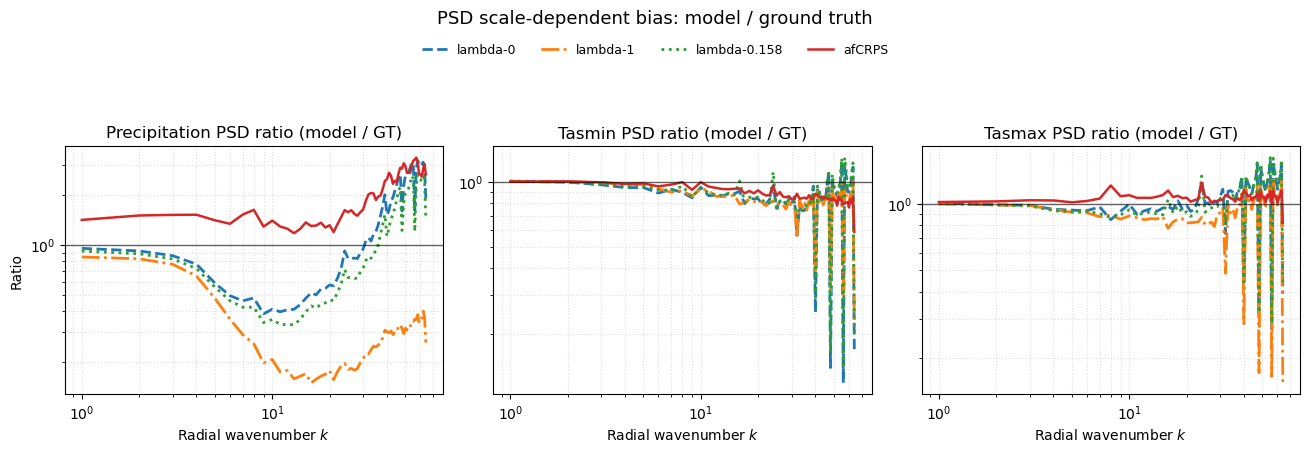

Saved: results/plots/08/18/202520:24:35/psd_ratio_3panel_4models.pdf


In [11]:
save_dir = os.path.join(
    "results", "plots",
    datetime.now().strftime("%m"),
    datetime.now().strftime("%d"),
    datetime.now().strftime("%Y%H:%M:%S")
)
os.makedirs(save_dir, exist_ok=True)

make_ratio = True
if make_ratio:
    fig, axes = plt.subplots(1, 3, figsize=(13.2, 3.8), sharex=True)
    for ax, v, title in zip(axes, ['pr', 'tasmin', 'tasmax'], ['Precipitation', 'Tasmin', 'Tasmax']):
        for label, style in model_styles.items():
            ratio = np.clip(psd_by_model[label][v] / (psd_gt[v] + 1e-12), 1e-6, 1e6)
            ax.loglog(kvals, ratio, label=label, **style)
        ax.axhline(1.0, color='black', lw=1, alpha=0.6)
        ax.set_title(f"{title} PSD ratio (model / GT)")
        ax.grid(True, which='both', ls=':', alpha=0.4)
    axes[0].set_xlabel('Radial wavenumber $k$')
    axes[1].set_xlabel('Radial wavenumber $k$')
    axes[2].set_xlabel('Radial wavenumber $k$')
    axes[0].set_ylabel('Ratio')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False, fontsize=9, bbox_to_anchor=(0.5, 1.12))
    plt.suptitle('PSD scale-dependent bias: model / ground truth', y=1.18, fontsize=13)
    plt.tight_layout()
    save_path = os.path.join(save_dir, "psd_ratio_3panel_4models.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


In [9]:
def hr_trans_to_real(hr_trans: torch.Tensor) -> torch.Tensor:
    """
    hr_trans: (T, 3, H, W) in stored 'transfo' domain
    returns:  (T, 3, H, W) in real units
    """
    T = hr_trans.shape[0]
    out = []
    for i in range(T):
        out.append(invert_transfo_3vars(hr_trans[i:i+1]).squeeze(0))
    return torch.stack(out, dim=0)

def preds_trans_to_real(preds_trans: torch.Tensor) -> torch.Tensor:
    """
    preds_trans: (T, M, 3, H, W) in 'transfo' domain
    returns:     (T, M, 3, H, W) in real units
    """
    T, M, C, H, W = preds_trans.shape
    out_T = []
    for i in range(T):
        out_M = []
        for m in range(M):
            out_M.append(invert_transfo_3vars(preds_trans[i, m:m+1]).squeeze(0))
        out_T.append(torch.stack(out_M, dim=0))
    return torch.stack(out_T, dim=0)


In [10]:

# # 1) Ground truth in REAL units (compute once)
all_hr_real = hr_trans_to_real(all_hr_trans_torch)  # (T, 3, H, W)

# # 2) For each checkpoint: run predictions (TRANSFO), convert to REAL, compute CRPS
# num_samples = 15
# crps_by_model = {}

# for path, label in models_info:  # same models_info you used for PSD
#     print(f"CRPS pass for: {label}")
#     model = load_probunet(path)
#     preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=num_samples)  # (T, M, 3, H, W)
#     preds_real  = preds_trans_to_real(preds_trans)                                           # (T, M, 3, H, W)
#     crps_dict   = crps_over_groundtruth(all_hr_real, preds_real)
#     crps_by_model[label] = crps_dict
#     print(f"  pr={crps_dict['pr']:.4f}, tasmin={crps_dict['tasmin']:.4f}, tasmax={crps_dict['tasmax']:.4f}")

# # 3) Pretty print as a small table
# print("\n== Mean CRPS (lower is better) ==")
# vars_order = ["pr", "tasmin", "tasmax"]
# header = "model      " + "  ".join([f"{v:>10}" for v in vars_order])
# print(header)
# for label in crps_by_model:
#     row = f"{label:<10} " + "  ".join([f"{crps_by_model[label][v]:10.4f}" for v in vars_order])
#     print(row)

# 2) For each checkpoint: run predictions (TRANSFO), convert to REAL, compute CRPS
num_samples = 15
crps_by_model = {}
crps_arrays_by_model = {}  # <-- NEW

for path, label in models_info:
    print(f"CRPS pass for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=num_samples)
    preds_real  = preds_trans_to_real(preds_trans)
    crps_means, crps_arrays = crps_over_groundtruth(all_hr_real, preds_real)  # <-- CHANGED
    crps_by_model[label] = crps_means
    crps_arrays_by_model[label] = crps_arrays  # <-- NEW
    print(f"  pr={crps_means['pr']:.4f}, tasmin={crps_means['tasmin']:.4f}, tasmax={crps_means['tasmax']:.4f}")


CRPS pass for: lambda-0
  pr=1.0720, tasmin=0.8568, tasmax=0.6818
CRPS pass for: lambda-1
  pr=1.1306, tasmin=0.7839, tasmax=0.5928
CRPS pass for: lambda-0.158
  pr=1.0593, tasmin=0.8502, tasmax=0.6594
CRPS pass for: afCRPS
  pr=0.9376, tasmin=0.6792, tasmax=0.6198


In [11]:
# Compute MAE for each model (using the same predictions from CRPS loop)
mae_by_model = {}
mae_arrays_by_model = {}  # <-- NEW

for path, label in models_info:
    print(f"MAE pass for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=num_samples)
    preds_real  = preds_trans_to_real(preds_trans)
    mae_means, mae_arrays = compute_mae(all_hr_real, preds_real)  # <-- CHANGED
    mae_by_model[label] = mae_means
    mae_arrays_by_model[label] = mae_arrays  # <-- NEW
    print(f"  pr={mae_means['pr']:.4f}, tasmin={mae_means['tasmin']:.4f}, tasmax={mae_means['tasmax']:.4f}")

# NEW: Add nearest neighbor baseline for MAE
print("MAE pass for: NN-baseline")
nn_predictions = nearest_neighbor_baseline(dataloader_test)  # [T, 3, H, W]
nn_mae_means, nn_mae_arrays = compute_mae(all_hr_real, torch.from_numpy(nn_predictions))
mae_by_model['NN-baseline'] = nn_mae_means
mae_arrays_by_model['NN-baseline'] = nn_mae_arrays
print(f"  pr={nn_mae_means['pr']:.4f}, tasmin={nn_mae_means['tasmin']:.4f}, tasmax={nn_mae_means['tasmax']:.4f}")

MAE pass for: lambda-0


  pr=1.2902, tasmin=1.0603, tasmax=0.8760
MAE pass for: lambda-1
  pr=1.1915, tasmin=0.9413, tasmax=0.7381
MAE pass for: lambda-0.158
  pr=1.2708, tasmin=1.0535, tasmax=0.8479
MAE pass for: afCRPS
  pr=1.3526, tasmin=0.9046, tasmax=0.7509
MAE pass for: NN-baseline
  pr=1.5077, tasmin=1.7579, tasmax=1.2957


In [13]:
# CHANGED: Updated table with both CRPS and MAE showing mean ± std
print("\n== Model Performance Comparison ==")
vars_order = ["pr", "tasmin", "tasmax"]

# CRPS table with std
print("CRPS (lower is better):")
header = "model      " + "  ".join([f"{v:>15}" for v in vars_order])
print(header)
for label in crps_by_model:
    row_parts = [f"{label:<10}"]
    for var in vars_order:
        mean_val = crps_by_model[label][var]
        std_val = np.std(crps_arrays_by_model[label][var])
        row_parts.append(f"{mean_val:7.4f}±{std_val:5.4f}")
    print(" ".join(row_parts))

# MAE table with std
print("\nMAE (lower is better):")
header = "model      " + "  ".join([f"{v:>15}" for v in vars_order])
print(header)
for label in mae_by_model:
    row_parts = [f"{label:<10}"]
    for var in vars_order:
        mean_val = mae_by_model[label][var]
        std_val = np.std(mae_arrays_by_model[label][var])
        row_parts.append(f"{mean_val:7.4f}±{std_val:5.4f}")
    print(" ".join(row_parts))


== Model Performance Comparison ==
CRPS (lower is better):
model                   pr           tasmin           tasmax
lambda-0    1.0720±0.8477  0.8568±0.2772  0.6818±0.1411
lambda-1    1.1306±0.8990  0.7839±0.2560  0.5928±0.1402
lambda-0.158  1.0593±0.8419  0.8502±0.2712  0.6594±0.1402
afCRPS      0.9376±0.7404  0.6792±0.2000  0.6198±0.1211

MAE (lower is better):
model                   pr           tasmin           tasmax
lambda-0    1.2902±0.9977  1.0603±0.3079  0.8760±0.1631
lambda-1    1.1915±0.9370  0.9413±0.2727  0.7381±0.1539
lambda-0.158  1.2708±0.9832  1.0535±0.3023  0.8479±0.1630
afCRPS      1.3526±1.0922  0.9046±0.2753  0.7509±0.1743
NN-baseline  1.5077±1.1361  1.7579±0.5953  1.2957±0.2977


Histogram pass for: lambda-0
Histogram pass for: lambda-1
Histogram pass for: lambda-0.158
Histogram pass for: afCRPS
Saved: results/plots/08/20/202513:14:20/hist_precip.pdf
Saved: results/plots/08/20/202513:14:20/hist_tasmin_tasmax.pdf


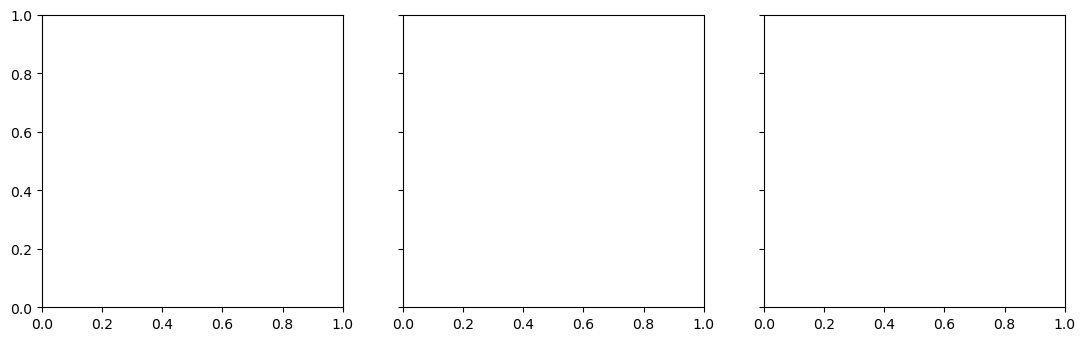

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime


save_dir = os.path.join(
    "results", "plots",
    datetime.now().strftime("%m"),
    datetime.now().strftime("%d"),
    datetime.now().strftime("%Y%H:%M:%S")
)
os.makedirs(save_dir, exist_ok=True)

# Config — set to False if you want exact log(count) (beware of -inf when a bin is empty)
ADD_ONE_IN_LOG = True            # use log(count+1) for numerical robustness
NBINS_PER_VAR  = 100
HIST_ENSEMBLE_MODE = 'ensemble_mean'  # or 'stack_ensemble'
LAYOUT = 'horizontal'            # 'horizontal' -> 1x3, 'vertical' -> 3x1
FILL_GT = True                   # fill grey under GT

# 1) Ground truth in REAL units
all_hr_real = hr_trans_to_real(all_hr_trans_torch)  # (T, 3, H, W)
hr_np = all_hr_real.cpu().numpy()

# 2) Build predictions for each model (REAL units), summarized as requested
vals_by_model = {}  # label -> (T,3,H,W) numpy
for path, label in models_info:
    print(f"Histogram pass for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=15)  # (T,M,3,H,W)
    preds_real  = preds_trans_to_real(preds_trans).cpu().numpy()
    if HIST_ENSEMBLE_MODE == 'ensemble_mean':
        vals_by_model[label] = preds_real.mean(axis=1)                          # (T,3,H,W)
    elif HIST_ENSEMBLE_MODE == 'stack_ensemble':
        T, M, C, H, W = preds_real.shape
        vals_by_model[label] = preds_real.reshape(T*M, C, H, W)                  # (T*M,3,H,W)
    else:
        raise ValueError("HIST_ENSEMBLE_MODE must be 'ensemble_mean' or 'stack_ensemble'")

# 3) Bin edges from GT min/max (paper snippet style)
pr_min, pr_max = hr_np[:, 0].min(), hr_np[:, 0].max()
tmin_min, tmin_max = hr_np[:, 1].min(), hr_np[:, 1].max()
tmax_min, tmax_max = hr_np[:, 2].min(), hr_np[:, 2].max()

edges_pr   = np.linspace(pr_min,   pr_max,   NBINS_PER_VAR)
edges_tmin = np.linspace(tmin_min, tmin_max, NBINS_PER_VAR)
edges_tmax = np.linspace(tmax_min, tmax_max, NBINS_PER_VAR)
edges_list = [edges_pr, edges_tmin, edges_tmax]

var_names  = ["Precipitation (mm/day)", "Tasmin (°C)", "Tasmax (°C)"]
var_idx    = [0, 1, 2]

# 4) Make figure with the requested size
# NOTE: Changed figsize and added sharey=True for consistency
fig, axs = plt.subplots(1, 3, figsize=(13.2, 3.8), sharey=True)
axs = np.ravel(axs)

# --- STYLING TO MATCH PSD PLOT ---
# NOTE: Using new labels and styles that match the models in this script
pretty_labels = {
    'lambda-0':     r'$\lambda=0$',
    'lambda-1':     r'$\lambda=1$',
    'lambda-0.158': r'$\lambda=0.158$',
    'afCRPS':       'afCRPS',
}

model_styles = {
    'lambda-0':     dict(ls='--', lw=1.8),
    'lambda-1':     dict(ls='-.', lw=1.8),
    'lambda-0.158': dict(ls=':',  lw=2.0),
    'afCRPS':       dict(ls='-',  lw=1.8),
}
# ------------------------------------

def log_counts(arr, edges):
    counts, edges_out = np.histogram(arr, bins=edges, density=False)
    if ADD_ONE_IN_LOG:
        y = np.log(counts + 1.0)
    else:
        # exact log(count); beware -inf for empty bins
        with np.errstate(divide='ignore'):
            y = np.log(counts)
    return y, edges_out

# --- 1) Precipitation: single figure, legend inside upper-right ---
fig_pr, ax_pr = plt.subplots(figsize=(5.0, 3.8))

# Ground truth
gt_pr = hr_np[:, 0].ravel()
y_gt, e_gt = log_counts(gt_pr, edges_pr)
ax_pr.stairs(y_gt, e_gt, color='black', label='Ground truth')
if FILL_GT:
    mids = 0.5*(e_gt[:-1] + e_gt[1:])
    ax_pr.fill_between(mids, y_gt, step='mid', color='lightgray', alpha=0.8)

# Models
for label, style in model_styles.items():
    arr = vals_by_model[label][:, 0].ravel()
    y_m, e_m = log_counts(arr, edges_pr)
    ax_pr.stairs(y_m, e_m, label=pretty_labels[label], **style)

ax_pr.set_xlabel("Precipitation (mm/day)")
ax_pr.set_ylabel("Log-Frequency")
ax_pr.grid(True, which='both', ls=':', alpha=0.35)

leg = ax_pr.legend(loc='upper right', frameon=True, fontsize=9)
leg.get_frame().set_alpha(0.9)

out_pr = os.path.join(save_dir, "hist_precip.pdf")
plt.tight_layout()
plt.savefig(out_pr, dpi=300, bbox_inches='tight')
plt.close(fig_pr)
print(f"Saved: {out_pr}")

# --- 2) Tasmin & Tasmax: two-panel figure, shared legend on top ---
fig_tt, axs_tt = plt.subplots(1, 2, figsize=(10.6, 3.8), sharey=True)

# Tasmin (left)
ax = axs_tt[0]
gt_tmin = hr_np[:, 1].ravel()
y_gt, e_gt = log_counts(gt_tmin, edges_tmin)
ax.stairs(y_gt, e_gt, color='black', label='Ground truth')
if FILL_GT:
    mids = 0.5*(e_gt[:-1] + e_gt[1:])
    ax.fill_between(mids, y_gt, step='mid', color='lightgray', alpha=0.8)
for label, style in model_styles.items():
    arr = vals_by_model[label][:, 1].ravel()
    y_m, e_m = log_counts(arr, edges_tmin)
    ax.stairs(y_m, e_m, label=pretty_labels[label], **style)
ax.set_xlabel("Tasmin (°C)")
ax.set_ylabel("Log-Frequency")
ax.grid(True, which='both', ls=':', alpha=0.35)

# Tasmax (right)
ax = axs_tt[1]
gt_tmax = hr_np[:, 2].ravel()
y_gt, e_gt = log_counts(gt_tmax, edges_tmax)
ax.stairs(y_gt, e_gt, color='black', label='Ground truth')
if FILL_GT:
    mids = 0.5*(e_gt[:-1] + e_gt[1:])
    ax.fill_between(mids, y_gt, step='mid', color='lightgray', alpha=0.8)
for label, style in model_styles.items():
    arr = vals_by_model[label][:, 2].ravel()
    y_m, e_m = log_counts(arr, edges_tmax)
    ax.stairs(y_m, e_m, label=pretty_labels[label], **style)
ax.set_xlabel("Tasmax (°C)")
ax.grid(True, which='both', ls=':', alpha=0.35)

# Shared legend on top (outside panels)
handles, labels = axs_tt[0].get_legend_handles_labels()
fig_tt.legend(handles, labels, loc='upper center', ncol=5, frameon=False, fontsize=9, bbox_to_anchor=(0.5, 1.03))

out_tt = os.path.join(save_dir, "hist_tasmin_tasmax.pdf")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the top legend
plt.savefig(out_tt, dpi=300, bbox_inches='tight')
plt.close(fig_tt)
print(f"Saved: {out_tt}")